# Classification: predicting client attrition with appropriate ML model

This notebook contains all neccessary stages for classificaition models development:
1. Data Preprocessing (Encoding, Imputation, Feature Engineering, Scaling, EDA)
2. Cross Validation (Finetuning hyperparameters)
3. Fitting model to the training data
4. Calculating separate performance metrics on a hold-out test set 

Responsible team member: Jan Frąckowiak

### Loading required libraries

In [138]:
import numpy as np # Linear algebra
import pandas as pd # Data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
# !pip install seaborn
import seaborn as sns
# !pip install imblearn
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, roc_curve, classification_report, accuracy_score, confusion_matrix, precision_score, recall_score, roc_auc_score, average_precision_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer
from sklearn.ensemble import ExtraTreesRegressor
# From sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score # For hyperparameters tuning
from sklearn.pipeline import Pipeline # Avoiding data-leakage
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import FunctionTransformer
# %pip install scikit-optimize
from skopt import gp_minimize
from skopt.space import Real, Categorical, Integer
import numpy as np

%pip install optuna
# Cross validation:
import optuna
import logging
import sys
from sklearn.metrics import balanced_accuracy_score
from sklearn.model_selection import StratifiedKFold

Note: you may need to restart the kernel to use updated packages.


## Loading Data

In [139]:
attrition_data = pd.read_csv('data/client_attrition_train.csv')
attrition_data.dtypes
attrition_data.shape

(10127, 21)

In [39]:
# Categorical Variables
non_num_part_of_attrition_data = attrition_data.select_dtypes(['object'])
columns = non_num_part_of_attrition_data.columns
for c in columns:
    print(attrition_data[c].value_counts())

customer_sex
F    4838
M    4271
Name: count, dtype: int64
customer_education
Graduate         3128
High School      2013
Unknown          1519
Uneducated       1487
College          1013
Post-Graduate     516
Doctorate         451
Name: count, dtype: int64
customer_civil_status
Married     4687
Single      3943
Unknown      749
Divorced     748
Name: count, dtype: int64
customer_salary_range
below 40K        3327
40-60K           1666
80-120K          1436
60-80K           1302
Unknown          1030
120K and more     685
Name: count, dtype: int64
credit_card_classification
Blue        9436
Silver       555
Gold         116
Platinum      20
Name: count, dtype: int64
account_status
open      8500
closed    1627
Name: count, dtype: int64


In [140]:
# Dropping customer id
attrition_data.drop("customer_id", inplace = True, axis = 1)

# Severe class imbalance! 
attrition_data['account_status'].value_counts()

account_status
open      8500
closed    1627
Name: count, dtype: int64

In [41]:
# Count NA Values
attrition_data.isna().sum()

customer_age                        624
customer_sex                       1018
customer_number_of_dependents         0
customer_education                    0
customer_civil_status                 0
customer_salary_range               681
customer_relationship_length          0
customer_available_credit_limit       0
credit_card_classification            0
total_products                        0
period_inactive                       0
contacts_in_last_year                 0
credit_card_debt_balance              0
remaining_credit_limit                0
transaction_amount_ratio              0
total_transaction_amount            407
total_transaction_count               0
transaction_count_ratio               0
average_utilization                   0
account_status                        0
dtype: int64

#### Observation: There are not many NA values, however the number increases drastically after recoding 'Unknown' values of features to NAs

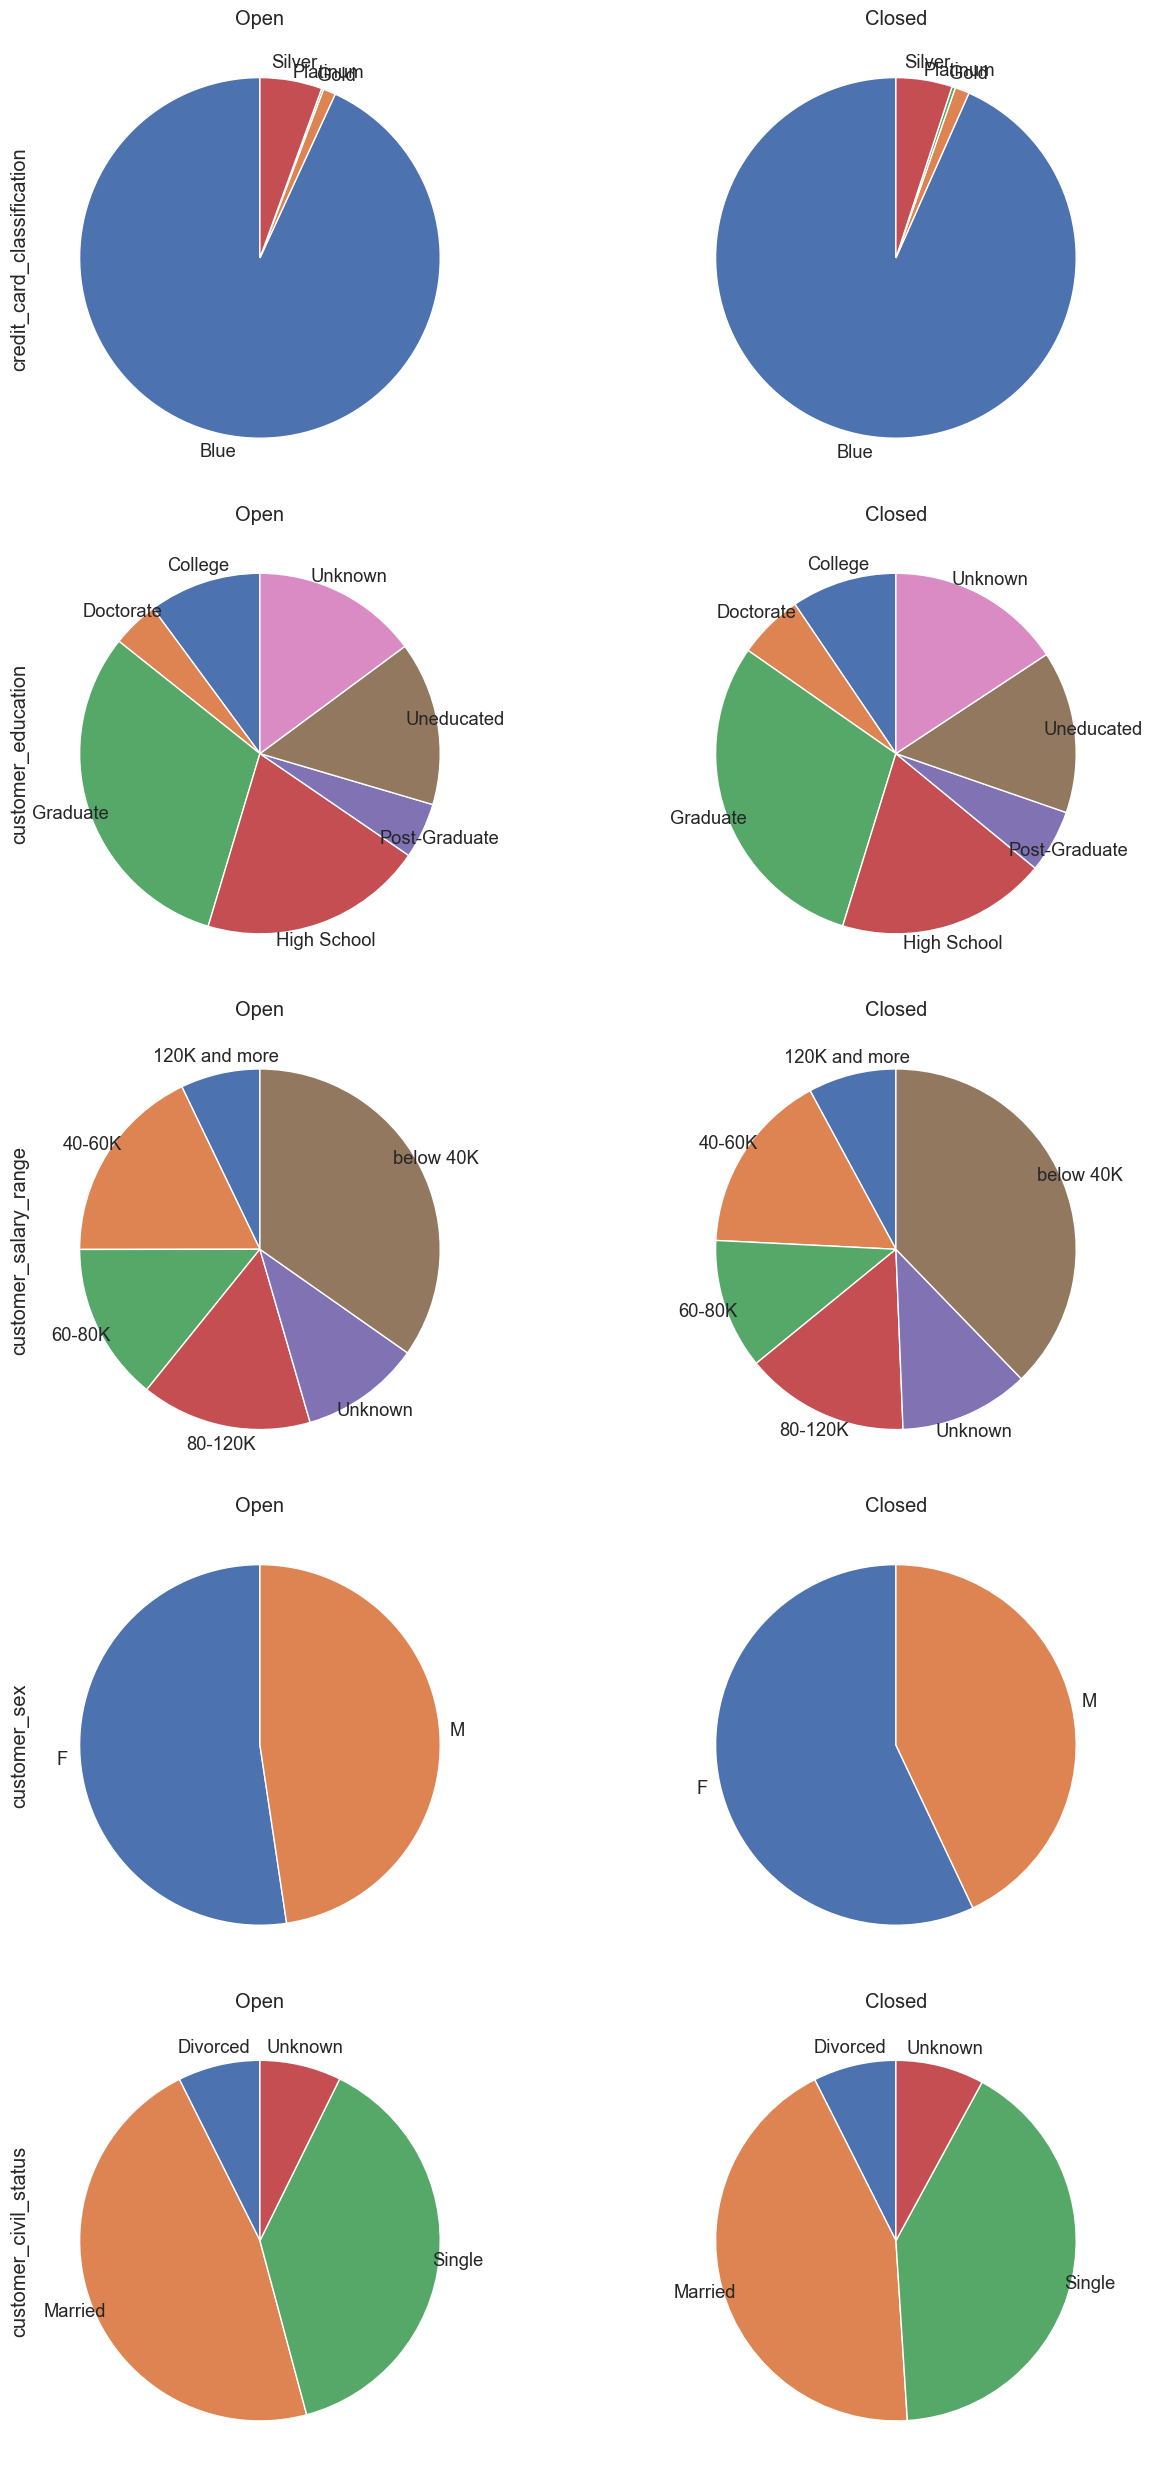

In [155]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(15, 25))
fig.subplots_adjust(hspace=0.5)

categories = ["credit_card_classification", "customer_education", "customer_salary_range", "customer_sex", "customer_civil_status"]

for i, cat in enumerate(categories):
    ax1 = axes[i, 0]
    ax2 = axes[i, 1]

    open_data = attrition_data.loc[attrition_data["account_status"] == "open", cat].reset_index().groupby(cat).size()
    closed_data = attrition_data.loc[attrition_data["account_status"] == "closed", cat].reset_index().groupby(cat).size()

    open_pie, open_labels, _ = ax1.pie(open_data, labels=open_data.index, autopct='', startangle=90)
    closed_pie, closed_labels, _ = ax2.pie(closed_data, labels=closed_data.index, autopct='', startangle=90)

    ax1.set_title("Open")
    ax2.set_title("Closed")

    ax1.set_ylabel(cat)
    ax2.set_ylabel("")  # Empty y-axis label for better alignment

    # Place names of values inside the pie charts
    for label in open_labels:
        label.set_horizontalalignment('center')
    for label in closed_labels:
        label.set_horizontalalignment('center')

plt.tight_layout()
plt.show()


#### Observation: Customer salary range is more frequently 'below 40k' in case of clients whose accounts were closed

## Data Encoding & Imputation



In [43]:
# Replacing unknown with nans where applicable 
attrition_data.loc[attrition_data['customer_salary_range']=='Unknown', 'customer_salary_range'] = np.nan
attrition_data.loc[attrition_data['customer_civil_status']=='Unknown', 'customer_civil_status'] = np.nan
attrition_data.loc[attrition_data['customer_education']=='Unknown', 'customer_education'] = np.nan

lb = LabelBinarizer()

# Function for encoding ordinal variables
def encode(data, order=[]):
    '''function to encode non-null data and replace it in the original data'''
    encoder = LabelEncoder()
    
    # Retains only non-null values
    nonulls = np.array(data.dropna())
    # Reshapes the data for encoding
    impute_reshape = nonulls.reshape(-1,1)
    # Encode date
    encoder.fit(order)
    impute_ordinal = encoder.transform(impute_reshape)
    
    # Assign back encoded values to non-null values
    data.loc[data.notnull()] = np.squeeze(impute_ordinal)
    return data

# Fit and transform status & customer_sex to binary variable
attrition_data['account_status'] = lb.fit_transform(attrition_data['account_status'])
attrition_data['customer_sex'] = attrition_data['customer_sex'].astype(str)
attrition_data['customer_sex'] = lb.fit_transform(attrition_data['customer_sex'])


# Changing type for ordinal vars
attrition_data['customer_salary_range'] = attrition_data['customer_salary_range'].astype(object)
attrition_data['customer_civil_status'] = attrition_data['customer_civil_status'].astype(object)
attrition_data['customer_education'] = attrition_data['customer_education'].astype(object)
attrition_data['credit_card_classification'] = attrition_data['credit_card_classification'].astype(object)

# Create a for loop to iterate through each column with ordinal var in the data
attrition_data['customer_salary_range'] = encode(attrition_data['customer_salary_range'], order = ["below 40K","40-60K","80-120K","60-80K","120K and more"])
attrition_data['customer_education'] = encode(attrition_data['customer_education'], order = ["High School", "Uneducated", "College", "Graduate", "Post-Graduate", "Doctorate"]) 
attrition_data['credit_card_classification'] = encode(attrition_data['credit_card_classification'], order = ["Blue", "Silver", "Gold", "Platinum"]) 



# dummies = pd.get_dummies(attrition_data['customer_civil_status'])
for col in ['customer_civil_status']: #, 'customer_salary_range', 'customer_education', 'credit_card_classification']:
    dummies = pd.get_dummies(attrition_data[col])

    # Add dummy variables to the original DataFrame, leaving NaNs untouched
    attrition_data = pd.concat([attrition_data, dummies], axis=1)
    attrition_data.drop([col], axis=1, inplace=True)

/var/folders/qb/z1cbz14x723cj5l8lxt1k2f00000gn/T/ipykernel_394/1411594039.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.loc[data.notnull()] = np.squeeze(impute_ordinal)
/var/folders/qb/z1cbz14x723cj5l8lxt1k2f00000gn/T/ipykernel_394/1411594039.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.loc[data.notnull()] = np.squeeze(impute_ordinal)
/var/folders/qb/z1cbz14x723cj5l8lxt1k2f00000gn/T/ipykernel_394/1411594039.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gui

## Dealing with Outliers (clipping the 98th and 99th percentile)

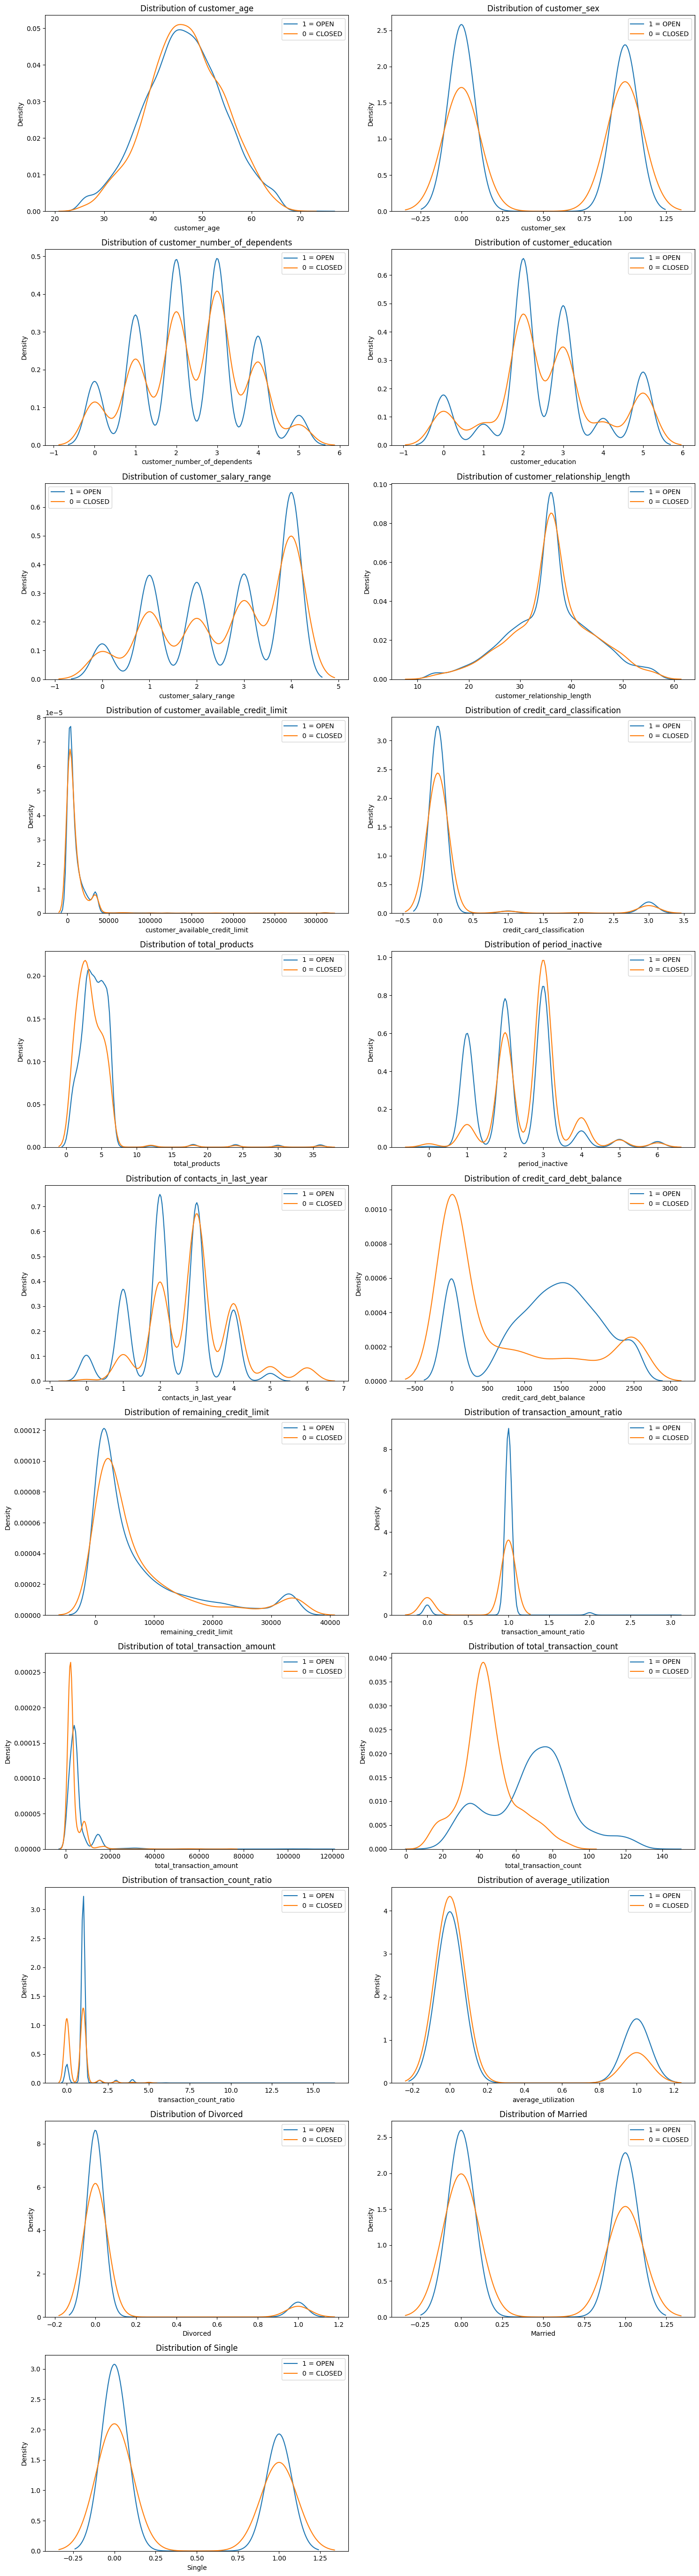

In [21]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

numeric_part_of_attrition_data = attrition_data.select_dtypes(['number'])
columns = numeric_part_of_attrition_data.columns.drop("account_status")

# Calculate the number of rows needed in the grid
nrows = len(columns) // 2 + len(columns) % 2

# Create the subplots grid
fig, axes = plt.subplots(nrows=nrows, ncols=2, figsize=(15, 5 * nrows))

# Flatten the grid for looping through subplots
axes = axes.flatten()

# Loop through the numerical columns and plot the density plots in each subplot
for i, column in enumerate(columns):
    sns.distplot(attrition_data.loc[attrition_data["account_status"]==1, column], hist=False, label="1 = OPEN", ax=axes[i])
    sns.distplot(attrition_data.loc[attrition_data["account_status"]==0, column], hist=False, label="0 = CLOSED", ax=axes[i])
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('Density')
    axes[i].set_title("Distribution of " + column)
    axes[i].legend()
    
# Remove the empty subplots
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

fig.tight_layout()


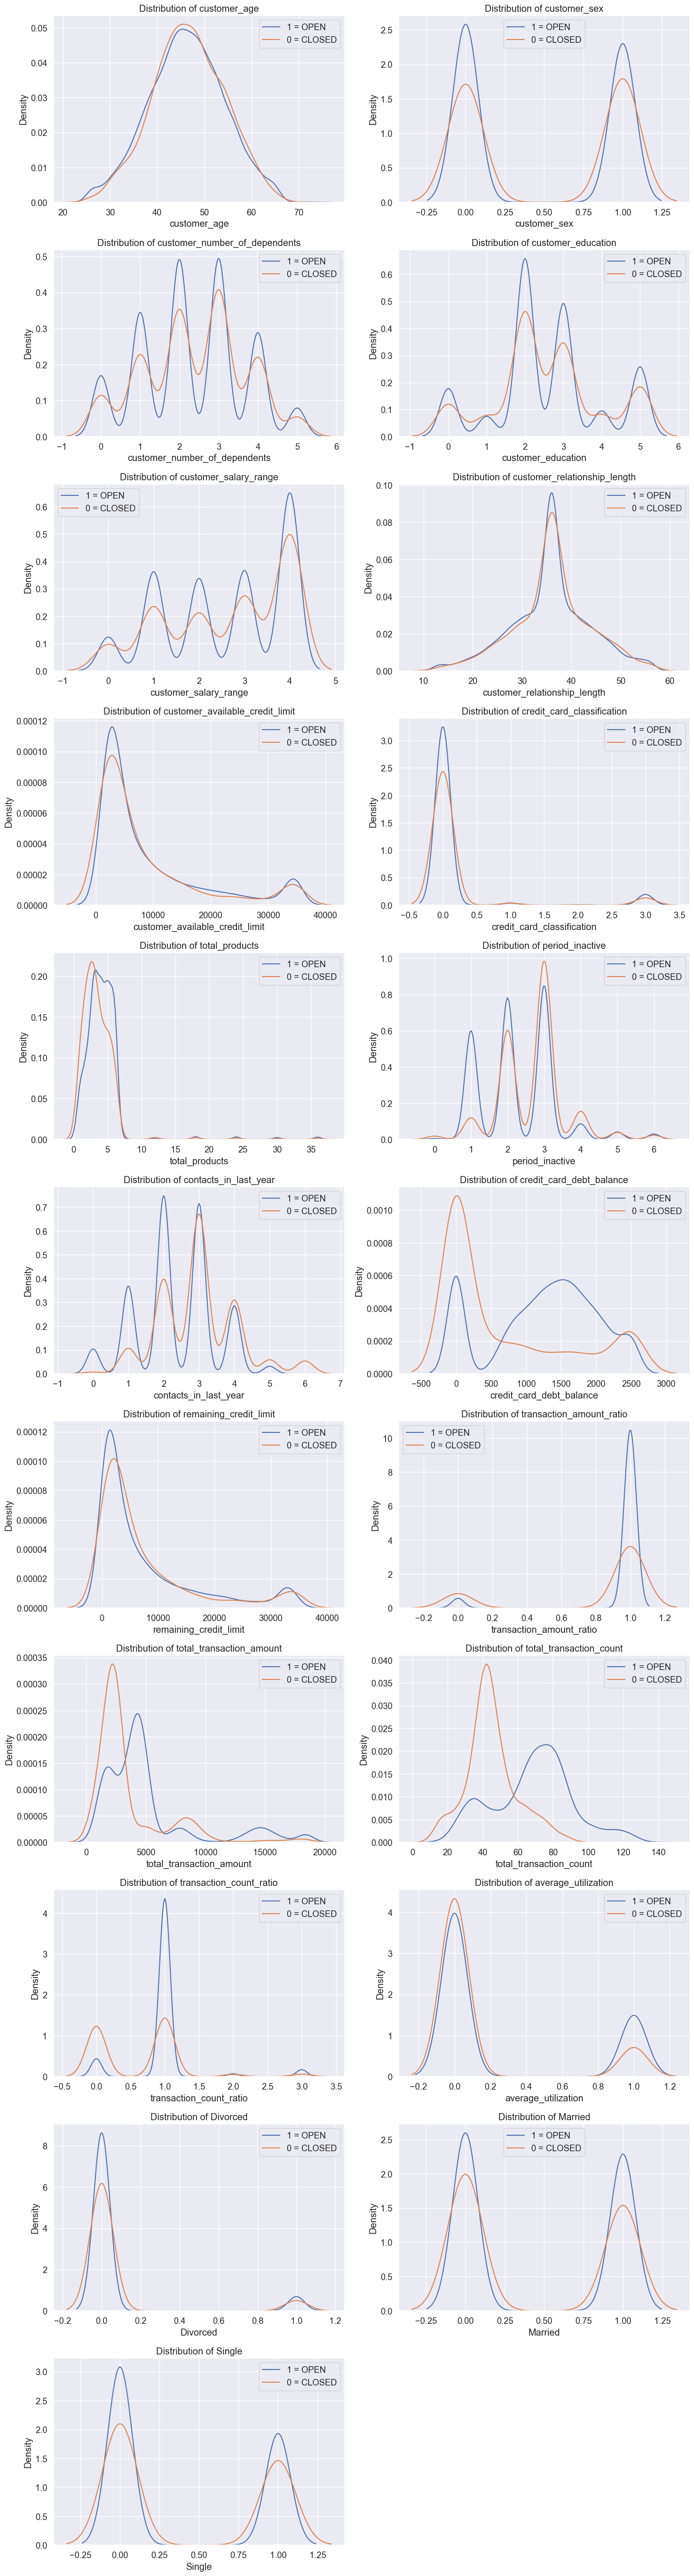

In [69]:
#CLIPPING
cutoff_transaction_count_ratio = attrition_data.transaction_count_ratio.quantile(0.98)
cutoff_total_transaction_amount = attrition_data.total_transaction_amount.quantile(0.98)
cutoff_transaction_amount_ratio = attrition_data.transaction_amount_ratio.quantile(0.98)
cutoff_customer_available_credit_limit = attrition_data.customer_available_credit_limit.quantile(0.98)

attrition_data["transaction_count_ratio"] = attrition_data.transaction_count_ratio.clip(upper=cutoff_transaction_count_ratio)
attrition_data["total_transaction_amount"] = attrition_data.total_transaction_amount.clip(upper=cutoff_total_transaction_amount)
attrition_data["transaction_amount_ratio"] = attrition_data.transaction_amount_ratio.clip(upper=cutoff_transaction_amount_ratio)
attrition_data["customer_available_credit_limit"] = attrition_data.customer_available_credit_limit.clip(upper=cutoff_customer_available_credit_limit)

# Distributions after clipping outliers
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

numeric_part_of_attrition_data = attrition_data.select_dtypes(['number'])
columns = numeric_part_of_attrition_data.columns.drop("account_status")

# Calculate the number of rows needed in the grid
nrows = len(columns) // 2 + len(columns) % 2

# Create the subplots grid
fig, axes = plt.subplots(nrows=nrows, ncols=2, figsize=(15, 5 * nrows))

# Flatten the grid for looping through subplots
axes = axes.flatten()

# Loop through the numerical columns and plot the density plots in each subplot
for i, column in enumerate(columns):
    sns.distplot(attrition_data.loc[attrition_data["account_status"]==1, column], hist=False, label="1 = OPEN", ax=axes[i])
    sns.distplot(attrition_data.loc[attrition_data["account_status"]==0, column], hist=False, label="0 = CLOSED", ax=axes[i])
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('Density')
    axes[i].set_title("Distribution of " + column)
    axes[i].legend()
    
# Remove the empty subplots
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

fig.tight_layout()

## Correlation & Variance between classes analysis

In [25]:
import scipy.stats as stats

# Calculate correlations
correlations, p_values = [], []
numeric_columns = attrition_data.select_dtypes(['number']).columns
target_variable = 'account_status'

for column in numeric_columns:
    correlation, p_value = stats.pearsonr(attrition_data[column], attrition_data[target_variable])
    correlations.append(correlation)
    p_values.append(p_value)

correlation_results = pd.DataFrame({'Variable': numeric_columns, 'Correlation': correlations, 'p-value': p_values})
correlation_results.sort_values(by='Correlation', inplace=True)

# Display correlation results
print('Most Positive Correlations:\n', correlation_results.tail(5))
print('\nMost Negative Correlations:\n', correlation_results.head(5))


Most Positive Correlations:
                     Variable  Correlation        p-value
13  transaction_amount_ratio     0.195095   1.948431e-87
16   transaction_count_ratio     0.216895  4.161141e-108
11  credit_card_debt_balance     0.263053  6.630148e-160
15   total_transaction_count     0.371403   0.000000e+00
18            account_status     1.000000   0.000000e+00

Most Negative Correlations:
                          Variable  Correlation       p-value
10          contacts_in_last_year    -0.204491  4.697490e-96
9                 period_inactive    -0.152449  1.032664e-53
1                    customer_sex    -0.029463  3.024833e-03
21                         Single    -0.019037  5.541023e-02
2   customer_number_of_dependents    -0.018991  5.600239e-02


#### Observation: These variables are expected to turn out most significant in modelling

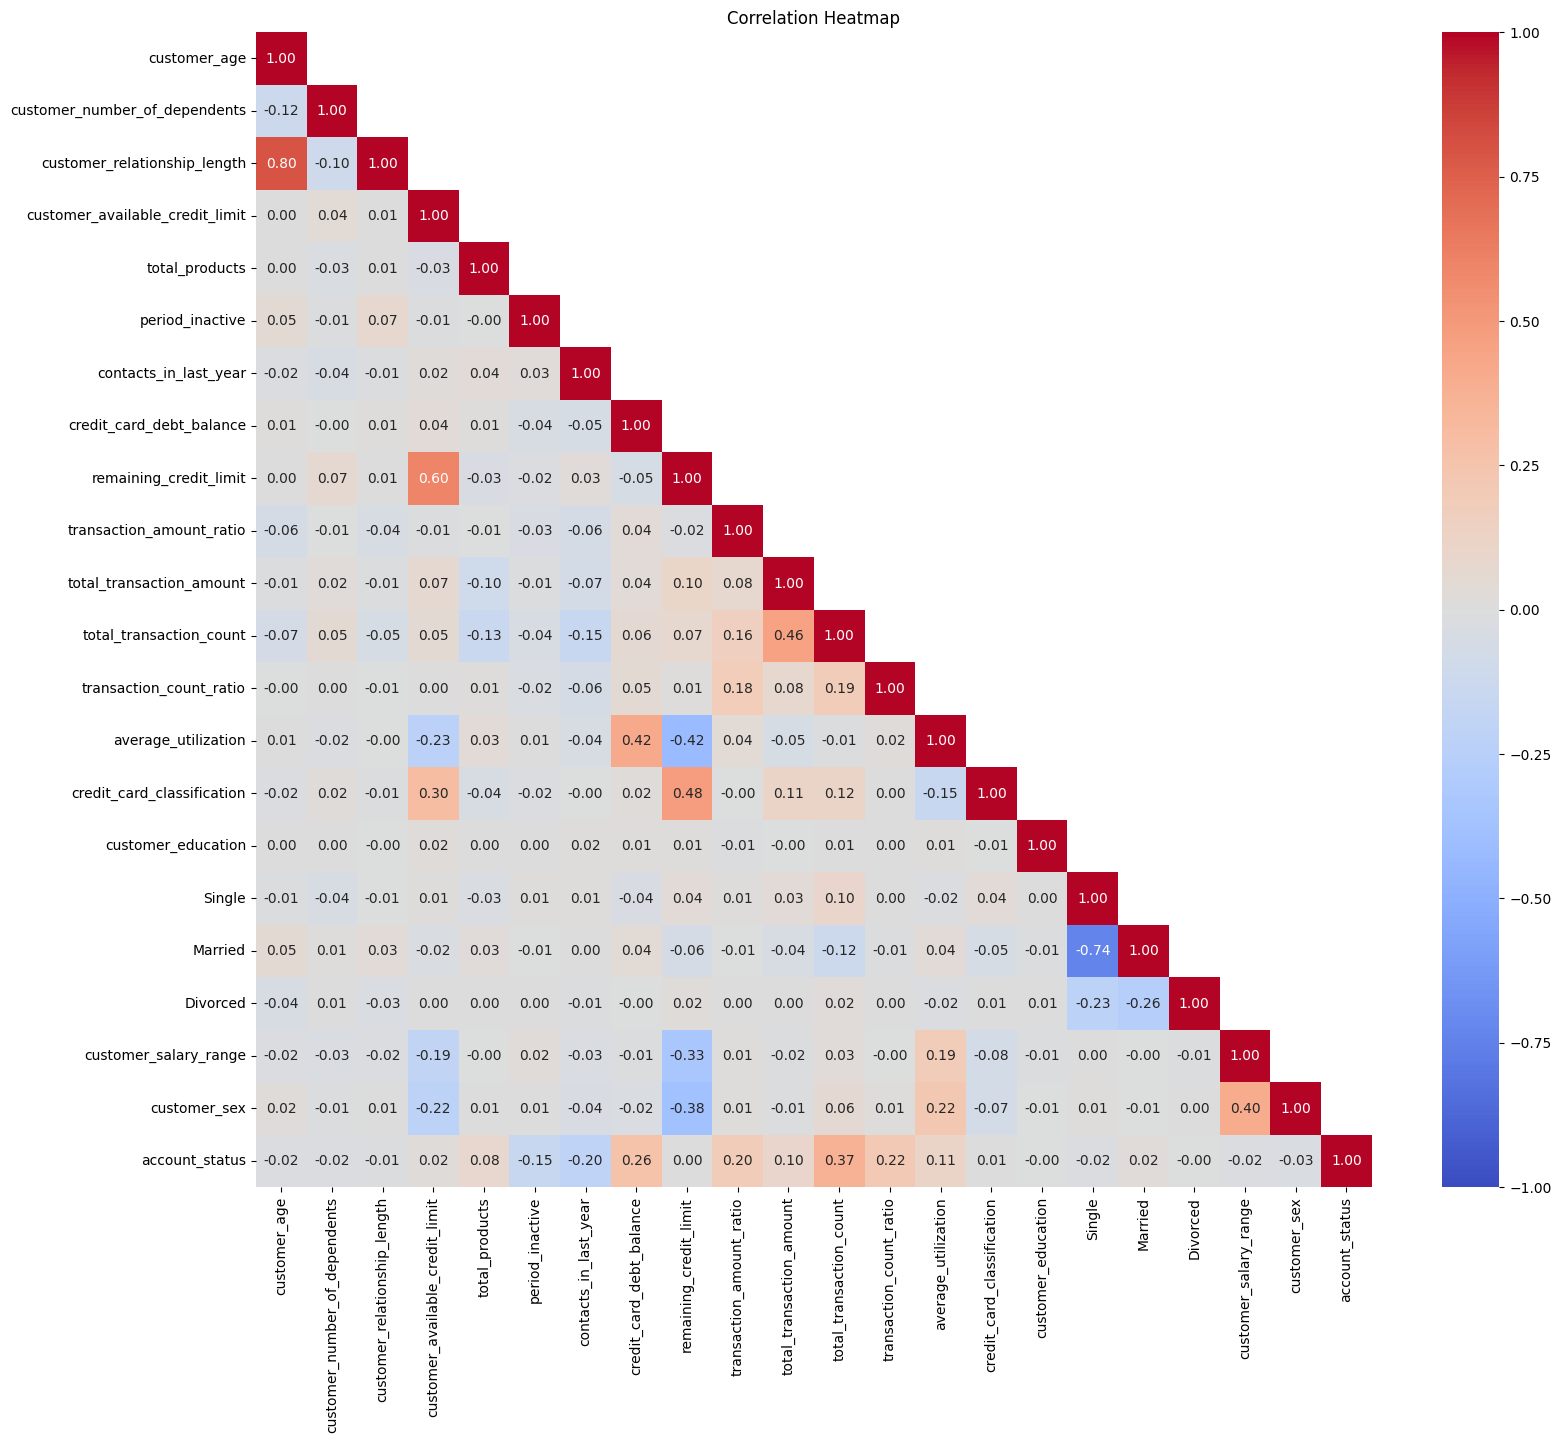

In [26]:
# Correlation table
attrition_data_selected = attrition_data[['customer_age', 'customer_number_of_dependents',
       'customer_relationship_length', 'customer_available_credit_limit',
       'total_products', 'period_inactive', 'contacts_in_last_year',
       'credit_card_debt_balance', 'remaining_credit_limit',
       'transaction_amount_ratio', 'total_transaction_amount',
       'total_transaction_count', 'transaction_count_ratio',
       'average_utilization',"credit_card_classification", "customer_education",
                  "Single", "Married", "Divorced", "customer_salary_range", "customer_sex", 'account_status']]

corr = attrition_data_selected.corr()
# Create a boolean mask for the upper triangle of the heatmap
mask = np.triu(np.ones_like(corr, dtype=bool))
np.fill_diagonal(mask, False)

plt.figure(figsize=(18,15))
sns.heatmap(corr, annot=True, fmt='.2f', vmin=-1.0, cmap='coolwarm', mask=mask)
plt.title('Correlation Heatmap')
plt.show()

In [28]:
# ANALYSIS OF VARIANCE INBETWEEN TARGET VARIABLE GROUPS
from scipy import stats

# Create an empty DataFrame to store ANOVA results
anova_results = pd.DataFrame(columns=attrition_data.columns)

# Perform ANOVA for each pair of variables
for column in attrition_data.loc[:, attrition_data.columns != 'account_status']:  # Exclude the target variable
    fvalue, pvalue = stats.f_oneway(attrition_data[column][attrition_data['account_status'] == 0], attrition_data[column][attrition_data['account_status'] == 1])
    anova_results.loc['F-value', column] = fvalue
    anova_results.loc['p-value', column] = pvalue

# Display the ANOVA results table
anova_results.T

# Interpretation: a low p-value suggests that there is strong evidence against the null
# Hypothesis that the difference between group means is insignificant

,F-value,p-value
customer_age,3.650561,0.056079
customer_sex,8.796682,0.003025
customer_number_of_dependents,3.652825,0.056002
customer_education,0.000226,0.988013
customer_salary_range,3.509922,0.061031
customer_relationship_length,1.897071,0.168437
customer_available_credit_limit,3.087001,0.07895
credit_card_classification,0.369161,0.543475
total_products,64.478363,0.0
period_inactive,240.910376,0.0


#### Observation: After performing correlation analysis and ANOVA we might consider dropping: 'Divorced', 'credit_card_classification', 'customer_education', 'remaining_credit_limit', 'customer_relationship_length' for not decision-tree based models (which have inbuilt mechanism for scoring significant variables)

In [47]:
# y and X set
y = attrition_data["account_status"].values
x = attrition_data.drop("account_status", axis = 1).values

## MODELLING : DATA split

## In classification problem two approaches to model performance validation proved useful:
1. Cross-validation with optuna package on entire train set
2. Choosing the best threshold under assumption that any improvements
on the randomly selected test set will transfer onto  entire dataset. 

In case of both data split and 5-fold cross-validation propotion between classes was maintained (risk associated with inbalanced datasets)

In [158]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = .2, random_state = 10)


In [108]:
print(np.unique(y_test, return_counts=True))
print(np.unique(y_train, return_counts=True))

print("Proportions of classes 0 to 1 in test set: ", 315/1711)
print("Proportions of classes 0 to 1 in train set: ", 1312/6789)

# Proportions are similar.

(array([0., 1.]), array([ 315, 1711]))
(array([0., 1.]), array([1312, 6789]))
Proportions of classes 0 to 1 in test set:  0.18410286382232613
Proportions of classes 0 to 1 in train set:  0.19325379290027986


## Models: establishing pipelines for each type of model + Cross-Validation

General pipeline consists of:
- Standard Scaler
- Polynomial Features generation
- Iterative Imputer (BayesianRidge)

In [77]:
# Preparing objects for validation on hold-out dataset (indepenent of CV)

# Scale the data
sc = StandardScaler()
sc.fit(x_train)

# Instantiate imputer (there are two listed as the best" ExtraTrees and BayesianRidge I am opting for te first one)
imputer = IterativeImputer(n_nearest_features=10, initial_strategy='mean', max_iter=10, random_state=42, tol=1e-3)
imputer.fit(x_train)

poly = PolynomialFeatures(degree=2)
poly.fit(x_train)


PolynomialFeatures()

## LOGISTIC REGRESSION: FINE-TUNNING + ESTIMATION

In [109]:
#Logistic Regression
# Import necessary libraries
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import balanced_accuracy_score
import optuna
import logging
import sys

# Define the objective function to be optimized
def objective(trial):
    C = trial.suggest_float('C', 1e-3, 1e3)
    penalty = trial.suggest_categorical('penalty', ['l2'])
    l1_ratio = trial.suggest_float('l1_ratio', 0, 1) if penalty == 'elasticnet' else None
    solver = trial.suggest_categorical('solver', ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'])
    max_iter = trial.suggest_int('max_iter', 100, 1000)
    n_jobs = -1

    # Define the pipeline
    pipeline = Pipeline([
        ('scaler', StandardScaler()),  # Step 2: StandardScaler for data scaling
        ('polynomial_features', PolynomialFeatures(degree=2)),  # Step 3: Polynomial feature generation
        ('imputer', IterativeImputer(n_nearest_features=10, initial_strategy='mean', max_iter=10, random_state=42, tol=1e-3)),  # Step 4: IterativeImputer for imputation
        ('classifier', LogisticRegression(C=C, penalty=penalty, l1_ratio=l1_ratio, solver=solver, max_iter=max_iter, n_jobs=n_jobs))  # Step 5: Logistic Regression classifier
    ])

    # Evaluate the model using cross-validation with balanced_accurac"y_score as the score metric
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    score = cross_val_score(pipeline, x, y, cv=cv, scoring='balanced_accuracy').mean()
    return score

# Run the hyperparameter optimization
study = optuna.create_study(direction='maximize', pruner=optuna.pruners.SuccessiveHalvingPruner())
study.optimize(objective, n_trials=10)

# Retrieve the best hyperparameters and the corresponding cross-validation score
best_params = study.best_params
best_score = study.best_value

print("Best hyperparameters: ", best_params)
print("Best cross-validation score: ", best_score)

[I 2023-07-18 13:45:15,194] A new study created in memory with name: no-name-25327e08-7cba-41fe-9adc-0ade8de00103
[I 2023-07-18 13:46:25,323] Trial 0 finished with value: 0.8040336451711406 and parameters: {'C': 341.83337609082747, 'penalty': 'l2', 'solver': 'liblinear', 'max_iter': 337}. Best is trial 0 with value: 0.8040336451711406.
[I 2023-07-18 13:47:25,830] Trial 1 finished with value: 0.8039748216417288 and parameters: {'C': 223.93184119223397, 'penalty': 'l2', 'solver': 'liblinear', 'max_iter': 607}. Best is trial 0 with value: 0.8040336451711406.
[I 2023-07-18 13:48:22,175] Trial 2 finished with value: 0.8039748216417288 and parameters: {'C': 312.5307631816234, 'penalty': 'l2', 'solver': 'liblinear', 'max_iter': 973}. Best is trial 0 with value: 0.8040336451711406.
/Users/mac/anaconda3/envs/ml-env/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase th

Best hyperparameters:  {'C': 481.8444796769032, 'penalty': 'l2', 'solver': 'newton-cg', 'max_iter': 342}
Best cross-validation score:  0.8042825139494212


In [110]:
# LogReg trained with inferred best set of parameters
n = 5
params = {'C': 481.8444796769032, 'penalty': 'l2', 'solver': 'newton-cg', 'max_iter': 342}
log = Pipeline([
        ('scaler', StandardScaler()),  # Step 2: StandardScaler for data scaling
        ('polynomial_features', PolynomialFeatures(degree=2)),  # Step 3: Polynomial feature generation
        ('imputer', IterativeImputer(n_nearest_features=10, initial_strategy='mean', max_iter=10, random_state=42, tol=1e-3)),  # Step 4: IterativeImputer for imputation
        ('classifier', LogisticRegression(**params))  # Step 5: Logistic Regression classifier
    ])
log.fit(x_train, y_train)
# y_pred = log.predict(x_test)

y_pred_proba = log.predict_proba(x_test)[:, 1]
threshold = 0.64
y_pred = (y_pred_proba >= threshold).astype(int)

0.9151 - Log Accuracy
0.9497 - Log Recall
0.9497 - Log Precision
0.8384 - Log ROC AUC
0.8384 - Log Balanced Acc
0.9444 - Log Average Precision


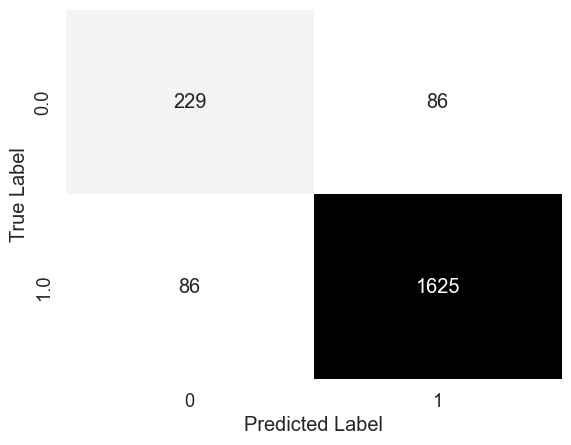

In [111]:
accuracy=accuracy_score(y_test, y_pred)
recall=recall_score(y_test,y_pred)
precision=precision_score(y_test,y_pred)
rocauc=roc_auc_score(y_test,y_pred)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
log_average_precision = average_precision_score(y_test, y_pred)

print('{:.4f}'.format(accuracy), '- Log Accuracy')
print('{:.4f}'.format(recall), '- Log Recall')
print('{:.4f}'.format(precision), '- Log Precision')
print('{:.4f}'.format(rocauc), '- Log ROC AUC')
print('{:.4f}'.format(balanced_accuracy), '- Log Balanced Acc')
print('{:.4f}'.format(log_average_precision), '- Log Average Precision')

confusion_matrix = pd.crosstab(y_test, y_pred)
sns.set(font_scale=1.2)
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Greys', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

## SUPPORT VECTOR MACHINE: FINE-TUNNING + ESTIMATION

In [115]:
# SVC fine-tuning

# Define the objective function to be optimized
def objective(trial):
    C = trial.suggest_float('C', 1e-1, 1e2)
    kernel = trial.suggest_categorical('kernel', ['linear', 'rbf', 'sigmoid'])
    gamma = trial.suggest_float('gamma', 1e-1, 1e1)
    degree = trial.suggest_int('degree', 2, 5)
    coef0 = trial.suggest_float('coef0', -1, 1)

    # Define the pipeline
    pipeline = Pipeline([
        ('scaler', StandardScaler()),  # Step 2: StandardScaler for data scaling
        #('polynomial_features', PolynomialFeatures(degree=2)),  # Step 3: Polynomial feature generation
        ('imputer', IterativeImputer(n_nearest_features=10, initial_strategy='mean', max_iter=10, random_state=42, tol=1e-3)),  # Step 4: IterativeImputer for imputation
        ('classifier', SVC(C=C, kernel=kernel, gamma=gamma, degree=degree, coef0=coef0))  # Step 5: SVM classifier
    ])


    # Evaluate the model using cross-validation with balanced_accuracy_score as the score metric
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    score = cross_val_score(pipeline, x, y, cv=cv, scoring='balanced_accuracy', n_jobs= -1).mean()
    return score

study = optuna.create_study(direction='maximize', pruner=optuna.pruners.SuccessiveHalvingPruner())
study.optimize(objective, n_trials=10)

print("Best hyperparameters: ", study.best_params)
print("Best cross-validation score: ", -study.best_value)

[I 2023-07-18 17:24:09,637] A new study created in memory with name: no-name-99d47c82-631a-4caa-9ccf-589aae1f2b0f
[I 2023-07-18 17:24:13,093] Trial 0 finished with value: 0.6114661743885851 and parameters: {'C': 88.03880110722969, 'kernel': 'sigmoid', 'gamma': 4.06421307205621, 'degree': 3, 'coef0': 0.14684598638237634}. Best is trial 0 with value: 0.6114661743885851.
[I 2023-07-18 17:24:16,106] Trial 1 finished with value: 0.6207410543264026 and parameters: {'C': 80.93315354523564, 'kernel': 'sigmoid', 'gamma': 6.622448301880754, 'degree': 3, 'coef0': -0.10823090675321811}. Best is trial 1 with value: 0.6207410543264026.
[I 2023-07-18 17:24:18,321] Trial 2 finished with value: 0.6125116175776587 and parameters: {'C': 46.6659008792588, 'kernel': 'sigmoid', 'gamma': 7.589153843068421, 'degree': 5, 'coef0': 0.3137630442168824}. Best is trial 1 with value: 0.6207410543264026.
[I 2023-07-18 17:24:20,336] Trial 3 finished with value: 0.5493957194014933 and parameters: {'C': 28.1395698404779

Best hyperparameters:  {'C': 50.19831643856736, 'kernel': 'linear', 'gamma': 3.477279926348704, 'degree': 2, 'coef0': 0.9604816101739917}
Best cross-validation score:  -0.7293252366543597


Best hyperparameters:  {'C = 16.88310244010329, kernel = 'rbf', gamma = 0.26780923825777314, degree = 4, coef0 = 0.4725497207575906} \
Best cross-validation score:  0.97...

In [123]:
# Training with fine-tuned set of parameters
params = {'probability':True, 'C': 50.19831643856736, 'kernel': 'linear', 'gamma': 3.477279926348704, 'degree': 2, 'coef0': 0.9604816101739917}

# Fit SVM classifier to training set
svc = Pipeline([
        ('scaler', StandardScaler()),  # Step 2: StandardScaler for data scaling
        #('polynomial_features', PolynomialFeatures(degree=2)),  # Step 3: Polynomial feature generation
        ('imputer', IterativeImputer(n_nearest_features=10, initial_strategy='mean', max_iter=10, random_state=42, tol=1e-3)),  # Step 4: IterativeImputer for imputation
        ('classifier', SVC(**params))]) # Step 5: SVM classifier

svc.fit(x_train,y_train)


# Make predictions on test set
# y_pred=svc.predict(x_test)
y_pred_proba = svc.predict_proba(x_test)[:, 1]

# Choosing custom threshold
threshold = 0.75
y_pred = (y_pred_proba >= threshold).astype(int)

0.8692 - Log Accuracy
0.8971 - Log Recall
0.9452 - Log Precision
0.8073 - Log ROC AUC
0.8073 - Log Balanced Acc


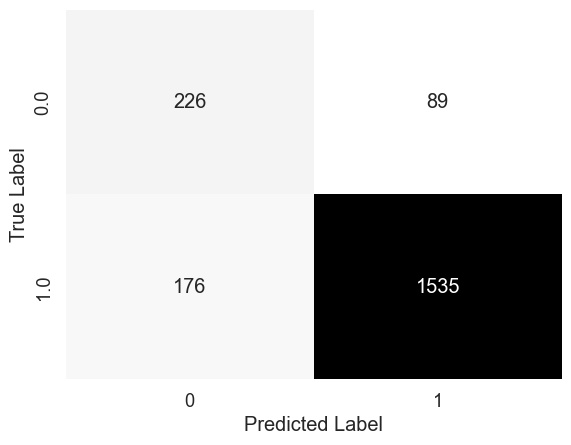

In [125]:
accuracy=accuracy_score(y_test, y_pred)
recall=recall_score(y_test,y_pred)
precision=precision_score(y_test,y_pred)
rocauc=roc_auc_score(y_test,y_pred)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred)

print('{:.4f}'.format(accuracy), '- Log Accuracy')
print('{:.4f}'.format(recall), '- Log Recall')
print('{:.4f}'.format(precision), '- Log Precision')
print('{:.4f}'.format(rocauc), '- Log ROC AUC')
print('{:.4f}'.format(balanced_accuracy), '- Log Balanced Acc')

confusion_matrix = pd.crosstab(y_test, y_pred)
sns.set(font_scale=1.2)
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Greys', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

## DECISON TREE: FINE-TUNNING + ESTIMATION

In [75]:
#Decision Trees fine-tuning

# Define the objective function to be optimized
def objective(trial):
    max_depth = trial.suggest_int('max_depth', 2, 32, log=True)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 20)
    max_features = trial.suggest_categorical('max_features', ['auto', 'sqrt', 'log2'])
    criterion = trial.suggest_categorical('criterion', ['gini', 'entropy'])
    

    
    # Define the pipeline
    pipeline = Pipeline([
        ('scaler', StandardScaler()),  # Step 2: StandardScaler for data scaling
        ('polynomial_features', PolynomialFeatures(degree=2)),  # Step 3: Polynomial feature generation
        ('imputer', IterativeImputer(n_nearest_features=10, initial_strategy='mean', max_iter=10, random_state=42, tol=1e-3)),  # Step 4: IterativeImputer for imputation
        ('classifier', DecisionTreeClassifier(max_depth=max_depth, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf,
                                 max_features=max_features, criterion=criterion, random_state=42))  # Step 5: Decision Tree classifier
    ])


    # Evaluate the model using cross-validation with accuracy as the score metric
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    score = cross_val_score(pipeline, x_train, y_train, cv=cv, scoring='balanced_accuracy').mean()
    return score

study = optuna.create_study(direction='maximize', pruner=optuna.pruners.SuccessiveHalvingPruner())
study.optimize(objective, n_trials=20)

print("Best hyperparameters: ", study.best_params)
print("Best cross-validation score: ", study.best_value)
 

[I 2023-07-18 13:15:00,684] A new study created in memory with name: no-name-334d731f-0bb1-489b-ab68-4626674232b7
[I 2023-07-18 13:15:05,734] Trial 0 finished with value: 0.5645785008280372 and parameters: {'max_depth': 2, 'min_samples_split': 17, 'min_samples_leaf': 10, 'max_features': 'log2', 'criterion': 'entropy'}. Best is trial 0 with value: 0.5645785008280372.
[I 2023-07-18 13:15:10,526] Trial 1 finished with value: 0.5477007206368056 and parameters: {'max_depth': 2, 'min_samples_split': 7, 'min_samples_leaf': 5, 'max_features': 'sqrt', 'criterion': 'entropy'}. Best is trial 0 with value: 0.5645785008280372.
[I 2023-07-18 13:15:15,525] Trial 2 finished with value: 0.7353428416549918 and parameters: {'max_depth': 5, 'min_samples_split': 17, 'min_samples_leaf': 7, 'max_features': 'sqrt', 'criterion': 'gini'}. Best is trial 2 with value: 0.7353428416549918.
[I 2023-07-18 13:15:20,420] Trial 3 finished with value: 0.6886507065293974 and parameters: {'max_depth': 4, 'min_samples_split

Best hyperparameters:  {'max_depth': 10, 'min_samples_split': 11, 'min_samples_leaf': 12, 'max_features': 'sqrt', 'criterion': 'entropy'}
Best cross-validation score:  0.8105955811420916


In [85]:
# DECISION TREE
params = {'max_depth': 10, 'min_samples_split': 11, 'min_samples_leaf': 12, 'max_features': 'sqrt', 'criterion': 'entropy'}
dtree = Pipeline([
        ('scaler', StandardScaler()),  # Step 2: StandardScaler for data scaling
        ('polynomial_features', PolynomialFeatures(degree=2)),  # Step 3: Polynomial feature generation
        ('imputer', IterativeImputer(n_nearest_features=10, initial_strategy='mean', max_iter=10, random_state=42, tol=1e-3)),  # Step 4: IterativeImputer for imputation
        ('classifier', DecisionTreeClassifier(**params))  # Step 5: XGBclassifier
    ])
# y_pred = dtree.predict(x_test)

dtree.fit(x_train, y_train)

y_pred_proba = dtree.predict_proba(x_test)[:, 1]

# Custom theresholding
threshold = 0.67
y_pred = (y_pred_proba >= threshold).astype(int)

0.9112 - Log Accuracy
0.8580 - Log Balanced Accuracy
0.9351 - Log Recall
0.9587 - Log Precision
0.8580 - Log ROC AUC


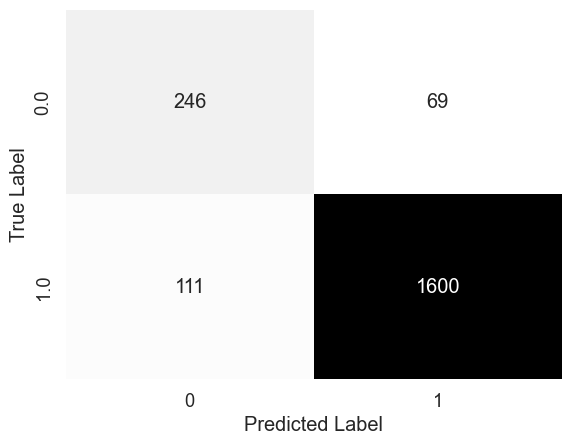

In [86]:
accuracy=accuracy_score(y_test, y_pred)
recall=recall_score(y_test,y_pred)
precision=precision_score(y_test,y_pred)
rocauc=roc_auc_score(y_test,y_pred)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred)

print('{:.4f}'.format(accuracy), '- Log Accuracy')
print('{:.4f}'.format(balanced_accuracy), '- Log Balanced Accuracy')
print('{:.4f}'.format(recall), '- Log Recall')
print('{:.4f}'.format(precision), '- Log Precision')
print('{:.4f}'.format(rocauc), '- Log ROC AUC')


confusion_matrix = pd.crosstab(y_test, y_pred)
sns.set(font_scale=1.2)
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Greys', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

## XG-BOOST classifier

In [87]:
from sklearn.model_selection import cross_val_score, StratifiedKFold
from xgboost import XGBClassifier
import optuna

def objective(trial):
    params = {
        'booster': 'gbtree',
        'n_jobs': -1,
        'seed': 42,
        'use_label_encoder': False,
        'tree_method': 'exact',
        'learning_rate': trial.suggest_float('learning_rate', 1e-5, 0.25),
        'gamma': trial.suggest_float('gamma', 0, 1),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'subsample': trial.suggest_float('subsample', 0.5, 1),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 10),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 10),
        'n_estimators': trial.suggest_int('n_estimators', 50, 200),
    }
    
    pipeline = Pipeline([
        ('scaler', StandardScaler()),  # Step 2: StandardScaler for data scaling
        ('polynomial_features', PolynomialFeatures(degree=2)),  # Step 3: Polynomial feature generation
        ('imputer', IterativeImputer(n_nearest_features=10, initial_strategy='mean', max_iter=10, random_state=42, tol=1e-3)),  # Step 4: IterativeImputer for imputation
        ('classifier', XGBClassifier(**params))  # Step 5: Logistic Regression classifier
    ])

    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    score = cross_val_score(pipeline, x_train, y_train, cv=cv, scoring='balanced_accuracy', error_score='raise').mean()
    return score

study = optuna.create_study(direction='maximize', pruner=optuna.pruners.SuccessiveHalvingPruner())
study.optimize(objective, n_trials=20)

print("Best hyperparameters: ", study.best_params)
print("Best cross-validation score: ", study.best_value)


[I 2023-07-18 13:23:03,130] A new study created in memory with name: no-name-394d7545-7c46-48b9-b404-d15b87c1e992
[I 2023-07-18 13:23:28,293] Trial 0 finished with value: 0.9010868861969502 and parameters: {'learning_rate': 0.1173073839691583, 'gamma': 0.19638543602451353, 'max_depth': 12, 'min_child_weight': 7, 'subsample': 0.7331809060121282, 'colsample_bytree': 0.5273921869322435, 'reg_alpha': 0.518256603374001, 'reg_lambda': 4.116271869138974, 'n_estimators': 112}. Best is trial 0 with value: 0.9010868861969502.
[I 2023-07-18 13:23:51,344] Trial 1 finished with value: 0.8959273817227521 and parameters: {'learning_rate': 0.21962044471669873, 'gamma': 0.042877795831945065, 'max_depth': 6, 'min_child_weight': 1, 'subsample': 0.8558010875378834, 'colsample_bytree': 0.8157928523791753, 'reg_alpha': 8.955660679768267, 'reg_lambda': 1.7643964361696118, 'n_estimators': 68}. Best is trial 0 with value: 0.9010868861969502.
[I 2023-07-18 13:24:12,285] Trial 2 finished with value: 0.8903838300

Best hyperparameters:  {'learning_rate': 0.1173073839691583, 'gamma': 0.19638543602451353, 'max_depth': 12, 'min_child_weight': 7, 'subsample': 0.7331809060121282, 'colsample_bytree': 0.5273921869322435, 'reg_alpha': 0.518256603374001, 'reg_lambda': 4.116271869138974, 'n_estimators': 112}
Best cross-validation score:  0.9010868861969502


In [130]:
#XGBoost

# Fine-tuned hyperparams
params = {'learning_rate': 0.1173073839691583, 'gamma': 0.19638543602451353, 'max_depth': 12, 'min_child_weight': 7, 'subsample': 0.7331809060121282,
          'colsample_bytree': 0.5273921869322435, 'reg_alpha': 0.518256603374001, 'reg_lambda': 4.116271869138974, 'n_estimators': 112}

xgb = Pipeline([
        ('scaler', StandardScaler()),  # Step 2: StandardScaler for data scaling
        ('polynomial_features', PolynomialFeatures(degree=2)),  # Step 3: Polynomial feature generation
        ('imputer', IterativeImputer(n_nearest_features=10, initial_strategy='mean', max_iter=10, random_state=42, tol=1e-3)),  # Step 4: IterativeImputer for imputation
        ('classifier', XGBClassifier(**params))  # Step 5: Logistic Regression classifier
    ])

xgb_no_polynomials = Pipeline([
        ('scaler', StandardScaler()),  # Step 2: StandardScaler for data scaling
        #('polynomial_features', PolynomialFeatures(degree=2)),  # Step 3: Polynomial feature generation
        ('imputer', IterativeImputer(n_nearest_features=10, initial_strategy='mean', max_iter=10, random_state=42, tol=1e-3)),  # Step 4: IterativeImputer for imputation
        ('classifier', XGBClassifier(**params))  # Step 5: Logistic Regression classifier
    ])

xgb.fit(x_train, y_train)
xgb_no_polynomials.fit(x_train, y_train)
y_pred = xgb.predict(x_test)

# Custom thresholding
y_pred_proba = xgb.predict_proba(x_test)[:, 1]
threshold = 0.74
y_pred_adjusted = (y_pred_proba >= threshold).astype(int)

Custom thresholding
0.9645 - Log Accuracy
0.9362 - Log Balanced Accuracy
0.9772 - Log Recall
0.9806 - Log Precision
0.9362 - Log ROC AUC
0.9775 - Log Average Precision


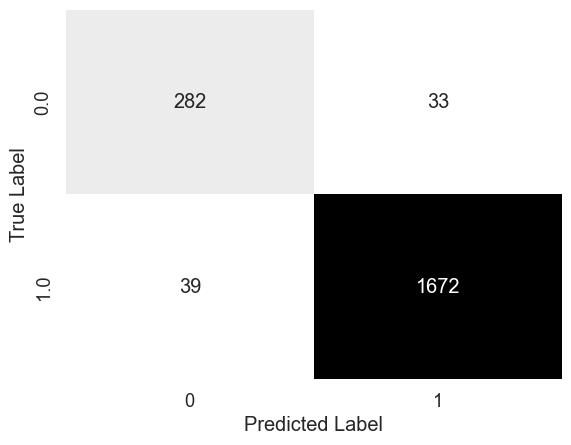

In [131]:
accuracy=accuracy_score(y_test, y_pred_adjusted)
recall=recall_score(y_test,y_pred_adjusted)
precision=precision_score(y_test,y_pred_adjusted)
rocauc=roc_auc_score(y_test,y_pred_adjusted)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred_adjusted)
log_average_precision = average_precision_score(y_test, y_pred_adjusted)

print('{:.4f}'.format(accuracy), '- Log Accuracy')
print('{:.4f}'.format(balanced_accuracy), '- Log Balanced Accuracy')
print('{:.4f}'.format(recall), '- Log Recall')
print('{:.4f}'.format(precision), '- Log Precision')
print('{:.4f}'.format(rocauc), '- Log ROC AUC')
print('{:.4f}'.format(log_average_precision), '- Log Average Precision')

confusion_matrix = pd.crosstab(y_test, y_pred_adjusted)
sns.set(font_scale=1.2)
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Greys', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

### XGBClassifier based feature-importance chart - it confirms conclusions drawn from the correlation analysis

Text(0.5, 1.0, 'Feature Importance')

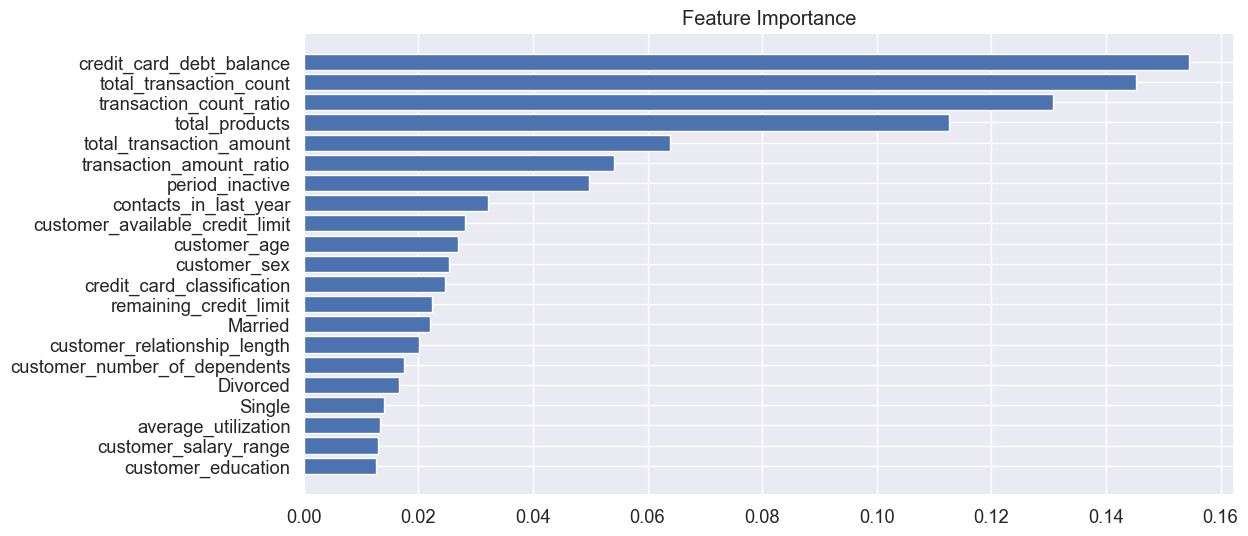

In [137]:
# Retrieve the trained XGBoost classifier from the pipeline
xgb_classifier = xgb_no_polynomials.named_steps['classifier']

# Set custom feature names
attrition_data_columns = attrition_data.columns.tolist()
feature_names = [col for col in attrition_data_columns if col != 'account_status']

feature_importance = xgb_classifier.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(feature_names)[sorted_idx])
plt.title('Feature Importance')
